# EV Charging Stations Usage 

## Bussiness Problem

The company's ( Planète OUI) Energy consumption prediction team is trying to optimize the energy distributions Grid network as per the energy required by every station
at different time intervals. Being able to predict when and how we’re using the energy, company can predict the consumption of every terminal and they can strategise their energy distribution system accordingly. By doing so, no stations will fall short of energy and where the demand is not much the energy will be distributed less.

## Problem Statement
The goal of this challenge is to predict the usage of Electric vehicle charging stations spread across Paris. Bassically, Its about to know when a particular charging station is available, actively charging a car, plugged, offline or down.

In [2]:
import numpy as np # Importing numpy for performing array and matrix operations 
import pandas as pd # Importing pandas to read data in dataframe

# Libraries to plot the distribution of classes 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime #I will use this to Convert ISO8601 format to unix time
from matplotlib.pyplot import figure


import time #I will use this to Convert ISO8601 format to unix time

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Information

The data for the current problem set is available on the Challenge data website, and It can be freely downloaded but one have to signup on the website in order to get the data. https://challengedata.ens.fr/challenges/57/

## Terminology


#### Terminal: 
It is a device on which an EV is charged
#### Station 
A group of terminals located at a unique physical location is called a station

At each time t, each terminal can be classified in one state:
#### Available 
The terminal is unplugged, means a car can come and recharge
#### Charging 
The terminal is charging the car at the current time stamp
#### Passive
The terminal is plugged, but it is not charging the EV
### Offline 
The terminal is not communicating its state, It may be in any mode

#### Down: 
the terminal is in maintenance and not available

Each terminal is identified by its id contructed as follow: S{sid}-T{tid} with {sid} the id of the station and {tid} the terminal number in the station. So all terminals belonging to the same station share the same S{sid} appendix.

### Dataset
The timseries data is given in Y_train and we can make our model on Y_train only. 
Some optionnal contextual information are given in X_train, X_test and Static_Info.

The training set is from November 25th 2019 to November 8th 2020
The testing set is from November 9th 2020 to November 22th 2020

All timestamps are in UTC
Timestamps are expressed under ISO format

When a state is unknown for a timestamp, the input is NaN and some of the time stamps may be missing


#### Timeseries : Y_train
A csv file  with one column per terminal and one row per timestamp is given 


## ML Problem Formulation
##### Time Series classification 

Given the terminal name and Time, classify the state(Available, Charging, Passive, Offline, Down) of the terminal 

### Metric
We are using Weighted F1 score. we can not use Acuuracy as a measure because accuracy is largely impacted by the class imbalance and takes into account the correctly classified points. If the model is really dumb it will still give us high accuracy due to the majority class. So, we womt be able to measure how good our model is performing.

To overcome the above issue  we use F1 score which will take into account the False positive(Precision) and False negatives(recall) predictions made by the classifier.

The metric used is a Weighted F1 score applied to a multiclass problem.

Terminology
S: states set. S = {Available, Charging, Passive, Offline, Down}

T: terminals set.

P{t,s}: Precision for terminal t ∈ T and state s ∈ S

R{t,s}: Recall for terminal t ∈ T and state s ∈ S

F1{t,s}: F1 score for terminal t ∈ T and state s ∈ S

F1{s}: F1 score for state s ∈ S over all terminals

Prob{s}: Probability of state s ∈ S over the dataset

F1{final}: Final F1 score


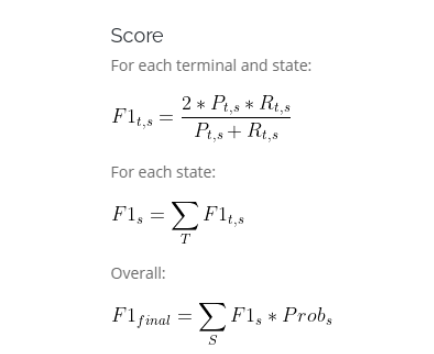

In [3]:
data= pd.read_csv('/content/drive/MyDrive/AAIC_Assignments/EV Usage/ytrain_NpxebDC.csv', parse_dates=['timestamp'],
index_col= ['timestamp'],) # Reading the csv file in data dataframe 

In [4]:
data.head(20) # Printing top 20 rows of the data 

,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,S62-T3,S14-T3,S8-T1,S8-T3,S34-T3,S6-T2,S29-T3,S64-T1,S11-T1,S76-T3,S59-T1,S58-T1,S58-T3,S21-T3,S96-T3,S30-T1,S77-T1,S35-T3,S71-T3,S89-T1,S51-T3,S51-T1,S38-T3,S79-T1,S79-T3,S33-T3,S33-T1,S50-T3,S1-T3,S49-T1,S60-T3,...,S71-T2,S36-T2,S79-T2,S16-T2,S94-T2,S9-T2,S21-T1,S92-T2,S11-T2,S51-T2,S60-T2,S19-T2,S62-T2,S31-T2,S96-T2,S27-T2,S23-T2,S28-T2,S37-T2,S39-T2,S68-T2,S56-T2,S41-T2,S35-T2,S7-T2,S75-T2,S20-T2,S95-T2,S5-T2,S2-T2,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-25 00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Available,Passive,Available,Available,Charging,Available,Available,Available,Passive,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Charging,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2019-11-25 00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Charging,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2019-11-25 00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2019-11-25 00:45:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Offline,Offline,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Offline,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2019-11-25 01:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Charging,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,D

In [5]:
data.tail() # printig the last rows of the data

,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,S62-T3,S14-T3,S8-T1,S8-T3,S34-T3,S6-T2,S29-T3,S64-T1,S11-T1,S76-T3,S59-T1,S58-T1,S58-T3,S21-T3,S96-T3,S30-T1,S77-T1,S35-T3,S71-T3,S89-T1,S51-T3,S51-T1,S38-T3,S79-T1,S79-T3,S33-T3,S33-T1,S50-T3,S1-T3,S49-T1,S60-T3,...,S71-T2,S36-T2,S79-T2,S16-T2,S94-T2,S9-T2,S21-T1,S92-T2,S11-T2,S51-T2,S60-T2,S19-T2,S62-T2,S31-T2,S96-T2,S27-T2,S23-T2,S28-T2,S37-T2,S39-T2,S68-T2,S56-T2,S41-T2,S35-T2,S7-T2,S75-T2,S20-T2,S95-T2,S5-T2,S2-T2,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-08 22:45:00+00:00,NaN,Available,NaN,Available,NaN,Available,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Passive,Available,Available,Available,NaN,NaN,NaN,Available,Charging,Passive,Available,Available,Available,Available,Available,Available,Charging,Available,Available,NaN,NaN,Available,NaN,Available,Available,...,Available,Charging,Available,Charging,Available,Available,Available,NaN,Charging,Charging,Available,NaN,NaN,Available,Charging,Available,NaN,Available,Available,Available,Available,Charging,NaN,Available,NaN,Available,Charging,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Available,Available,Available,Available
2020-11-08 23:00:00+00:00,NaN,Available,NaN,Available,NaN,Available,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Passive,Available,Available,Available,NaN,NaN,NaN,Available,Available,Passive,Available,Available,Available,Available,Available,Available,Charging,Available,Available,NaN,NaN,Available,NaN,Available,Available,...,Available,Charging,Available,Charging,Available,Available,Available,NaN,Charging,Charging,Available,NaN,NaN,Available,Charging,Available,NaN,Available,Available,Available,Available,Charging,NaN,Available,NaN,Available,Charging,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Available,Available,Available,Available
2020-11-08 23:15:00+00:00,NaN,Available,NaN,Available,NaN,Available,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Passive,Available,Available,Available,NaN,NaN,NaN,Available,Available,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,NaN,NaN,Available,NaN,Available,Available,...,Available,Available,Available,Charging,Available,Available,Available,NaN,Charging,Charging,Available,NaN,NaN,Available,Charging,Available,NaN,Available,Available,Available,Available,Charging,NaN,Available,NaN,Available,Charging,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Available,Available,Available,Available
2020-11-08 23:30:00+00:00,NaN,Available,NaN,Available,NaN,Available,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Passive,Available,Available,Available,NaN,NaN,NaN,Available,Available,Passive,Available,Available,Available,Available,Available,Available,Charging,Available,Available,NaN,NaN,Available,NaN,Available,Available,...,Available,Available,Available,Charging,Available,Available,Available,NaN,Charging,Charging,Available,NaN,NaN,Available,Charging,Available,NaN,Available,Available,Available,Available,Charging,NaN,Available,NaN,Available,Charging,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Available,Available,Available,Available
2020-11-08 23:45:00+00:00,NaN,Available,NaN,Available,NaN,Available,Available,Available,Available,NaN,NaN,Available,Available,Available,Available,Passive,Available,Available,Available,NaN,NaN,NaN,Available,Available,Passive,Available,Available,Available,Available,Available,Available,Charging,Available,Available,NaN,NaN,Available,NaN,Available,Available,...,Available,Available,Available,Charging,Available,Available,Available,NaN,Charging,Charging,Available,NaN,NaN,Available,Charging,Available,NaN,Available,Available,Available,Avail

In [6]:
data.apply(pd.value_counts)

,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,S62-T3,S14-T3,S8-T1,S8-T3,S34-T3,S6-T2,S29-T3,S64-T1,S11-T1,S76-T3,S59-T1,S58-T1,S58-T3,S21-T3,S96-T3,S30-T1,S77-T1,S35-T3,S71-T3,S89-T1,S51-T3,S51-T1,S38-T3,S79-T1,S79-T3,S33-T3,S33-T1,S50-T3,S1-T3,S49-T1,S60-T3,...,S71-T2,S36-T2,S79-T2,S16-T2,S94-T2,S9-T2,S21-T1,S92-T2,S11-T2,S51-T2,S60-T2,S19-T2,S62-T2,S31-T2,S96-T2,S27-T2,S23-T2,S28-T2,S37-T2,S39-T2,S68-T2,S56-T2,S41-T2,S35-T2,S7-T2,S75-T2,S20-T2,S95-T2,S5-T2,S2-T2,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
Available,NaN,17156,30005.0,19931,NaN,22718.0,22811.0,15468,30512.0,NaN,1596,13550.0,15011,14939.0,17681,27479.0,27842.0,23385,23295.0,16360,8140,8073,11389,22204.0,22485.0,16098,21266.0,19407.0,20101.0,17482.0,18928.0,20168.0,19682,21280,30743.0,30743.0,24886.0,24659,20340,20680.0,...,27744.0,20068,21598,22841.0,17211.0,12026.0,9104,7873,20406,20893.0,23073.0,30005.0,NaN,15104.0,22998.0,24716,22909.0,30512.0,24653.0,26354,17179.0,22220,10817.0,22415,NaN,19310,15153,12191.0,19463,17370,NaN,14247.0,11988,11345,21040,20266,7685.0,7287.0,23306.0,21278
Charging,NaN,282,NaN,2977,NaN,3044.0,3370.0,1444,NaN,NaN,130,1419.0,1110,1861.0,1664,787.0,1246.0,2797,3448.0,9,173,45,1042,2967.0,3650.0,2518,9.0,4809.0,4214.0,4589.0,3355.0,4049.0,15,38,NaN,NaN,3752.0,2594,6,3019.0,...,2254.0,7518,14,2968.0,317.0,3521.0,1632,12,4081,2411.0,1569.0,NaN,NaN,958.0,2474.0,2015,844.0,NaN,2.0,3163,561.0,1231,284.0,5,NaN,4210,2915,NaN,2689,87,NaN,550.0,1070,915,1665,2408,12.0,NaN,NaN,609
Down,30005.0,524,NaN,6427,30005.0,NaN,NaN,69,NaN,30838.0,20819,NaN,2,NaN,1148,NaN,NaN,16,NaN,3,21436,21768,466,NaN,NaN,96,NaN,NaN,NaN,NaN,NaN,NaN,1629,1233,NaN,NaN,NaN,81,3003,NaN,...,NaN,52,995,NaN,NaN,NaN,1053,978,41,NaN,NaN,NaN,30838.0,NaN,NaN,2293,NaN,NaN,NaN,37,NaN,6427,NaN,2,30005.0,569,592,2.0,46,429,30005.0,NaN,150,149,43,300,NaN,NaN,NaN,1696
Offline,NaN,12928,NaN,884,NaN,2938.0,2951.0,13287,NaN,NaN,7393,12587.0,12556,13139.0,10044,1115.0,1255.0,2325,247.0,8159,460,126,17277,2966.0,817.0,8774,2545.0,228.0,4085.0,6871.0,6868.0,2490.0,696,688,NaN,NaN,1330.0,275,3177,5805.0,...,215.0,716,687,2937.0,13285.0,14152.0,17299,18117,2313,6860.0,5771.0,NaN,NaN,14500.0,2966.0,553,6308.0,NaN,691.0,662,12778.0,1233,19258.0,2544,NaN,5337,11221,15578.0,8075,13159,NaN,14256.0,17052,17676,7701,1848,17315.0,16281.0,653.0,268
Passive,NaN,192,NaN,945,NaN,2530.0,2098.0,951,NaN,NaN,67,3643.0,2520,1217.0,690,1453.0,882.0,2702,4234.0,6024,18,215,908,3093.0,4231.0,3657,7402.0,6781.0,2817.0,2280.0,2071.0,4513.0,9181,7964,NaN,NaN,1249.0,2966,4699,1681.0,...,1012.0,2869,7909,2484.0,406.0,1063.0,1994,3025,4384,1058.0,772.0,NaN,NaN,652.0,2792.0,1608,277.0,NaN,5672.0,998,686.0,53,271.0,6256,NaN,1798,1338,2727.0,945,37,NaN,952.0,864,997,777,1649,431.0,425.0,111.0,104


From the above description of the every column we can see that most of the time a terminals lavel is not specified so I will mark NAN values with the Down label 

In [7]:
for col in data:    # for every column in the data frame
    if col!='timestamp':
        data[col]=data[col].fillna('Down')  # Filling the missing class label with Down as explained above
data['S7-T1'].isnull().sum() # counting the NAN values

0

In [8]:
data.head()

,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,S62-T3,S14-T3,S8-T1,S8-T3,S34-T3,S6-T2,S29-T3,S64-T1,S11-T1,S76-T3,S59-T1,S58-T1,S58-T3,S21-T3,S96-T3,S30-T1,S77-T1,S35-T3,S71-T3,S89-T1,S51-T3,S51-T1,S38-T3,S79-T1,S79-T3,S33-T3,S33-T1,S50-T3,S1-T3,S49-T1,S60-T3,...,S71-T2,S36-T2,S79-T2,S16-T2,S94-T2,S9-T2,S21-T1,S92-T2,S11-T2,S51-T2,S60-T2,S19-T2,S62-T2,S31-T2,S96-T2,S27-T2,S23-T2,S28-T2,S37-T2,S39-T2,S68-T2,S56-T2,S41-T2,S35-T2,S7-T2,S75-T2,S20-T2,S95-T2,S5-T2,S2-T2,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-25 00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Available,Passive,Available,Available,Charging,Available,Available,Available,Passive,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Charging,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,Down,Down,Down,Down,Down
2019-11-25 00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Charging,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,Down,Down,Down,Down,Down
2019-11-25 00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,Down,Down,Down,Down,Down
2019-11-25 00:45:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Offline,Offline,Available,Available,Available,Available,Available,Available,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Offline,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Available,Charging,Down,Down,Offline,Offline,Available,Available,Down,Down,Down,Down,Down
2019-11-25 01:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,Down,Down,Offline,Offline,Offline,Offline,Available,Available,Offline,Passive,Available,Available,Available,Passive,Available,Passive,Passive,Passive,Available,Available,Available,Available,Available,Available,Available,Available,Available,Charging,Available,Offline,Passive,...,Charging,Charging,Available,Offline,Offline,Offline,Available,Available,Offline,Available,Available,Available,Down,Offline,Available,Available,Offline,Available,Passive,Passive,Offline,Down,Offline,Available,Down,Offline,Offline,Avail

In [ ]:
def status(data, state):
    '''This function takes the dataFrame as an Input and the class label 
    of the terminal and returns the top 5 terminals that are in the class mode 
    provided as the function
    '''
    pas_lst=[]
    for i in range(0,data.shape[1]): # for every column in the dataframe
      try:
        # counts how many time a terminal is in that state and stores it in a list
        pas_lst.append(data[data.columns[i]].value_counts() .state) 
      except:
        pas_lst.append(0)
    # Sorting the list and returning the index of the sorted list
    pas_lst=np.argsort(pas_lst)
    return pas_lst[-5:]

#### Plotting the top 5 terminals that were passive most of the time 

<bound method Figure.show of <Figure size 1584x360 with 5 Axes>>

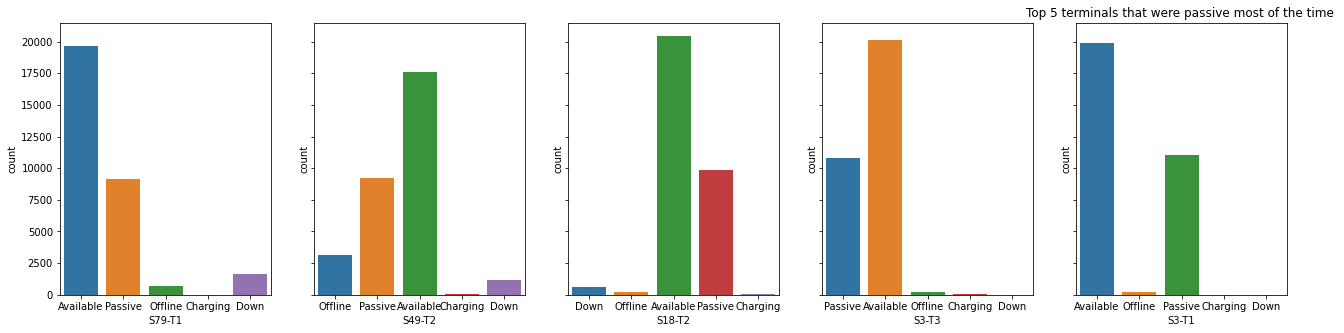

In [9]:
pas_lst=[]
for i in range(0,data.shape[1]):
  try:
    pas_lst.append(data[data.columns[i]].value_counts() .Passive)
  except:
    pas_lst.append(0)
pas_lst=np.argsort(pas_lst)
lst=pas_lst[-5:]

f, axes = plt.subplots(1, 5, sharey=True,figsize=(22, 5))
index=0
for i in lst:
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
plt.title("Top 5 terminals that were passive most of the time ")
f.show

#### Top passive terminals on weekdays

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

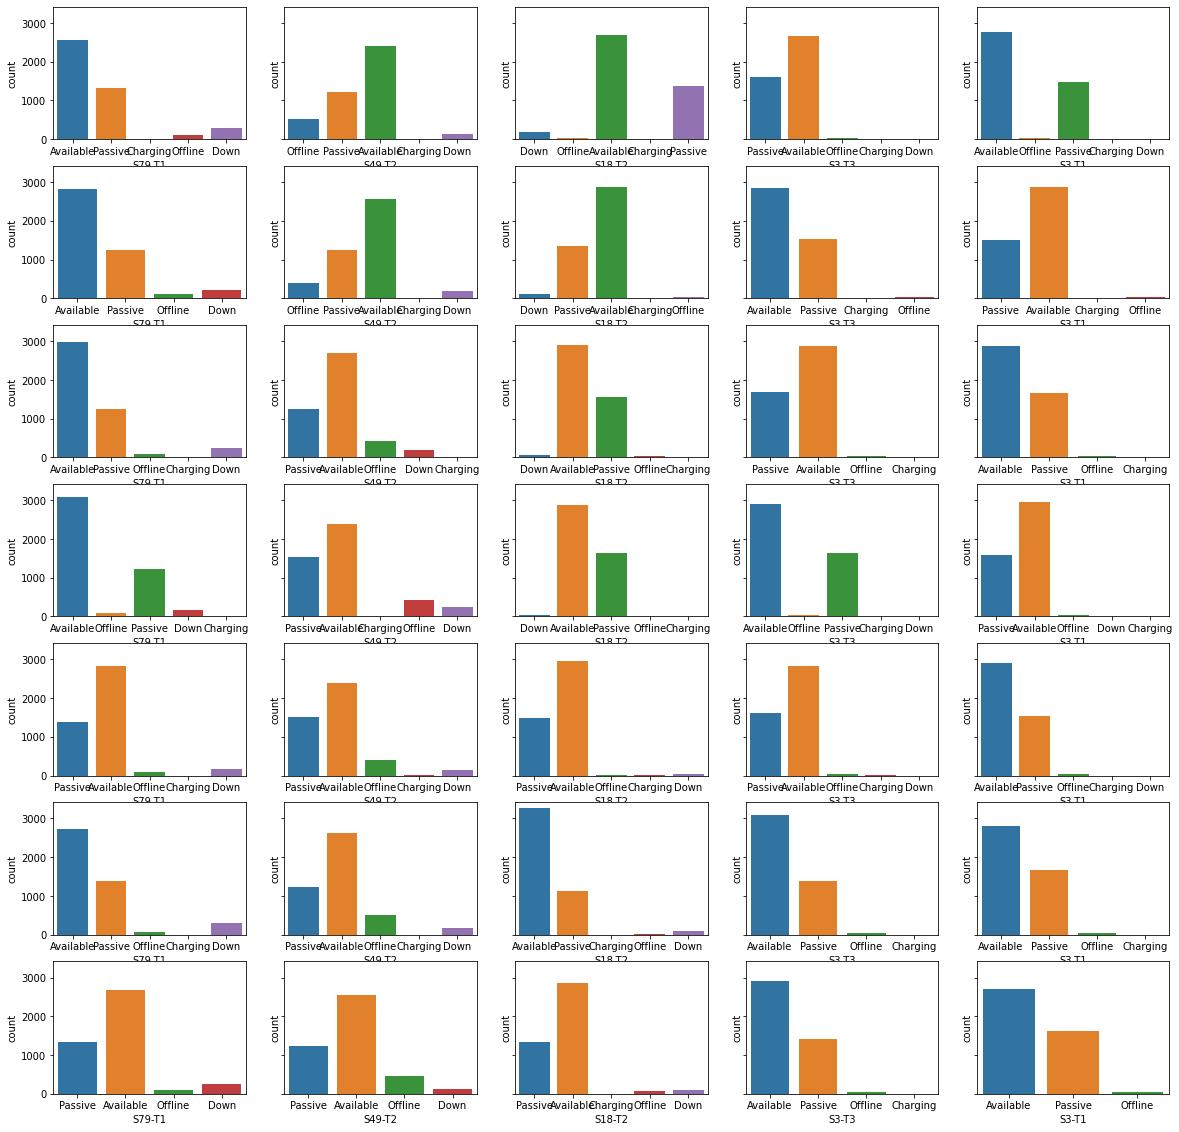

In [10]:
# Plotting the count of status of top 5 terminals on weekdays
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in lst: 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

In [11]:
str=data.columns[lst[0]]
print(str)

S79-T1


##### Behavior of Top passive terminals on Monthly basis

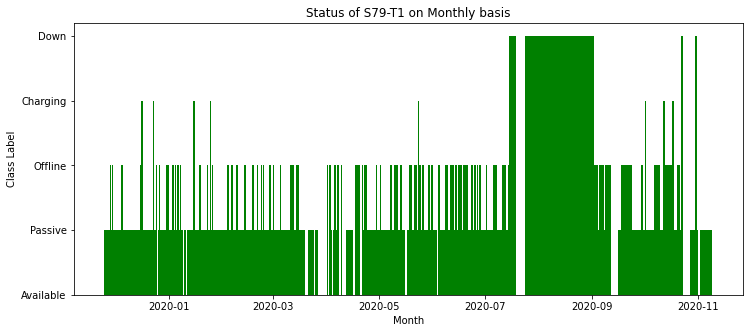

In [12]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[0]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[0]]))

f.show()

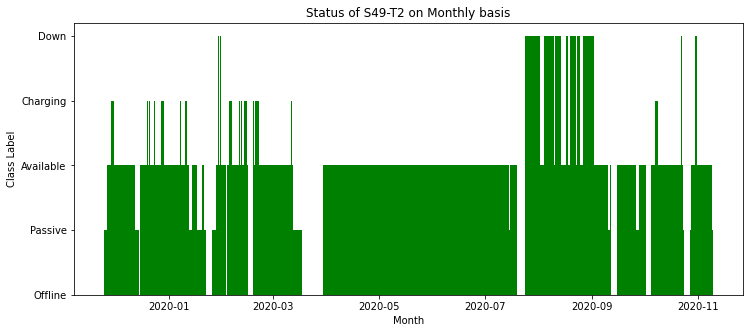

In [13]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[1]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[1]]))

f.show()

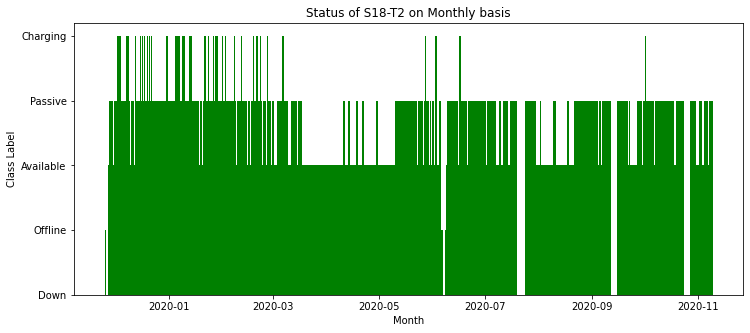

In [14]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[2]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[2]]))

f.show()

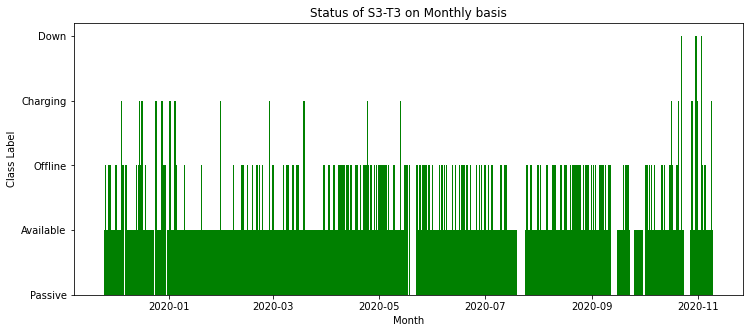

In [15]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[3]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[3]]))

f.show()

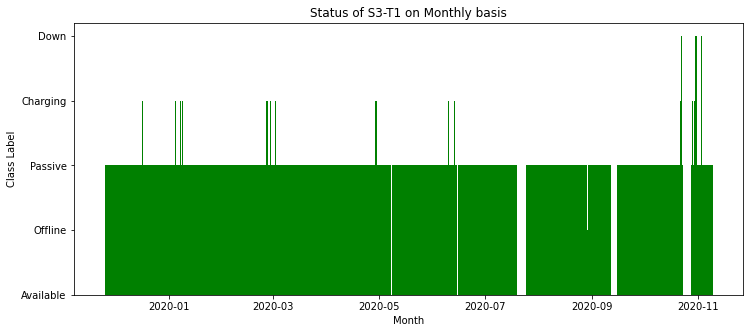

In [16]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[4]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[4]]))

f.show()

#### Top passive terminals after 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

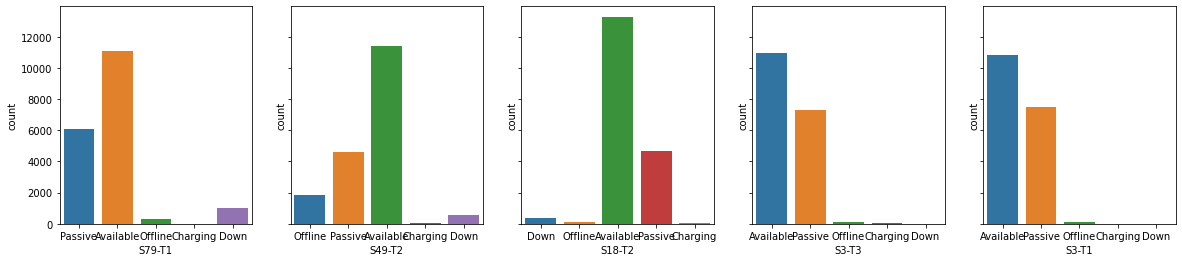

In [24]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour>9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### TOP Passive terminal before 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

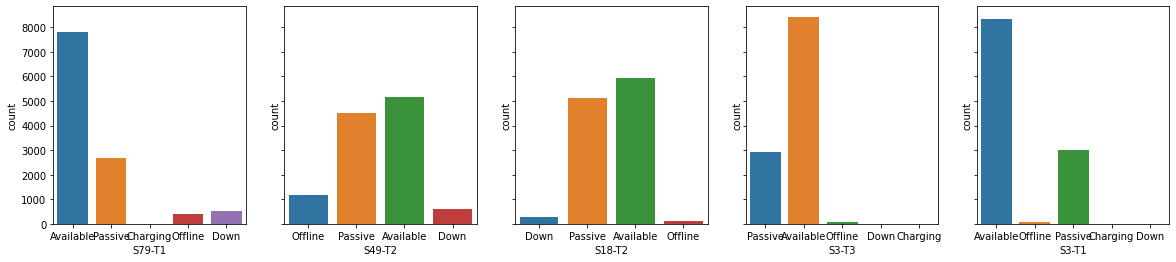

In [25]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour<9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

### Observation
1. From the above plots, it can be observed that these terminals were also available to charge the car, but passive means the car was connected but the terminal was not delivering the energy.
2. So, It can be concluded that when the cars were needed the energy the terminals did not have.


#### Plots of terminal that were available most of the time

<bound method Figure.show of <Figure size 1584x360 with 5 Axes>>

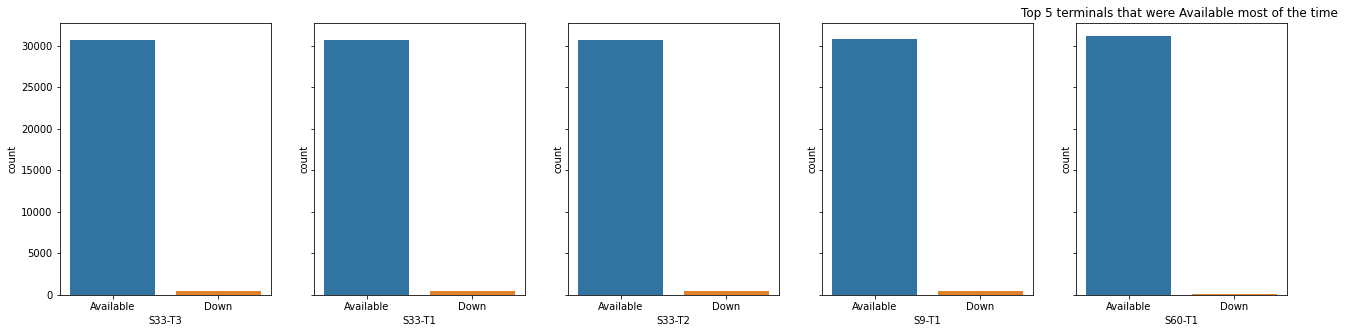

In [27]:
pas_lst=[]
for i in range(0,data.shape[1]):
  try:
    pas_lst.append(data[data.columns[i]].value_counts() .Available)
  except:
    pas_lst.append(0)
pas_lst=np.argsort(pas_lst)
lst=pas_lst[-5:]

f, axes = plt.subplots(1, 5, sharey=True,figsize=(22, 5))
index=0
for i in lst:
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
plt.title("Top 5 terminals that were Available most of the time ")
f.show

#### Top Available terminal on weekdays

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

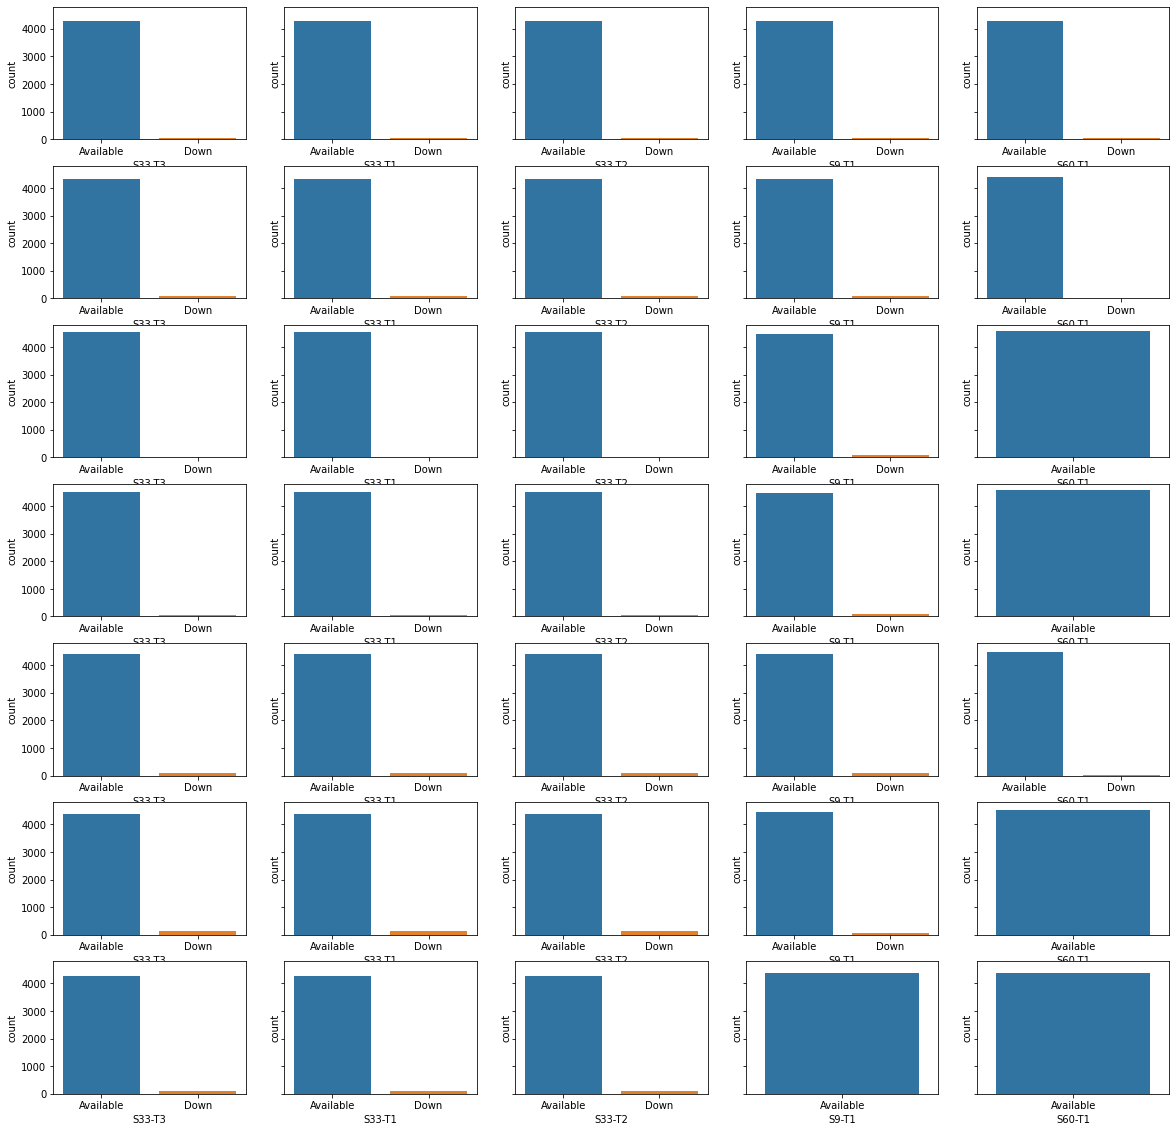

In [28]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in lst: 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

##### Top Available terminals on Monthly basis

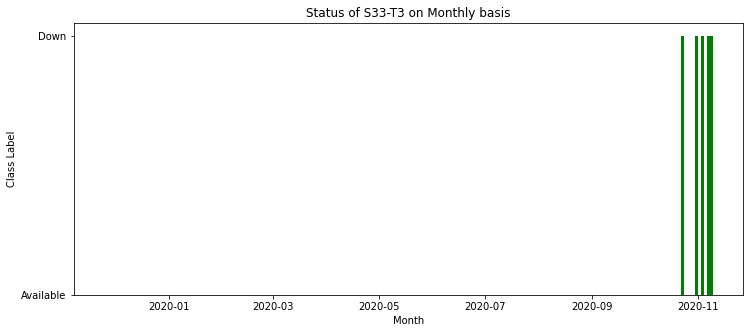

In [29]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[0]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[0]]))

f.show()

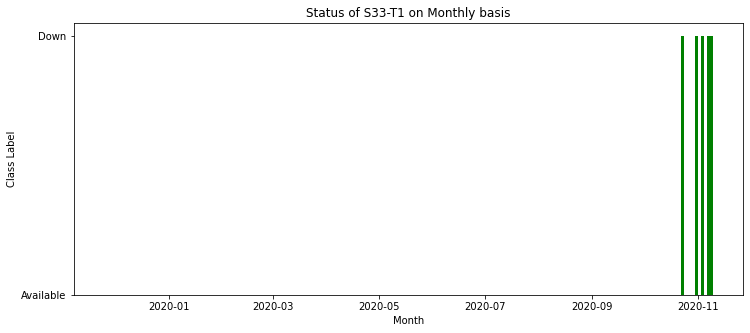

In [30]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[1]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[1]]))

f.show()

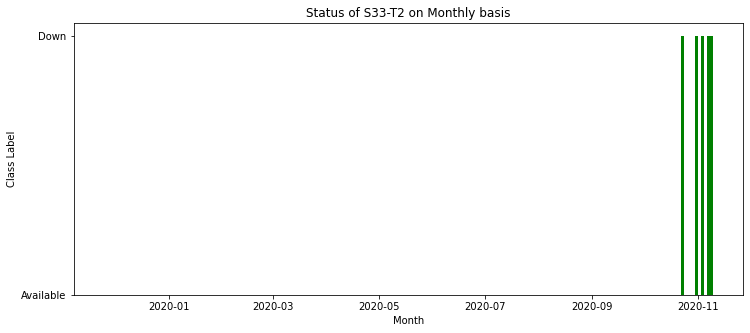

In [31]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[2]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[2]]))

f.show()

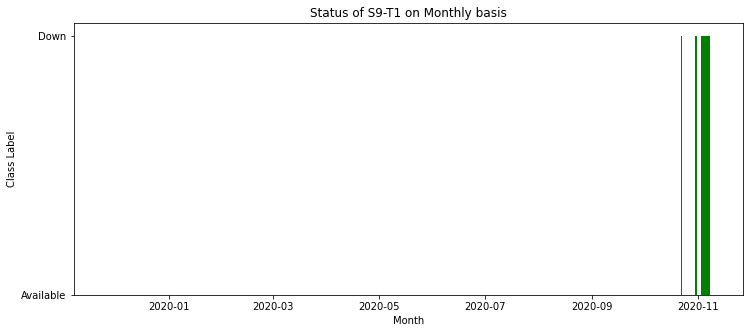

In [32]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[3]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[3]]))

f.show()

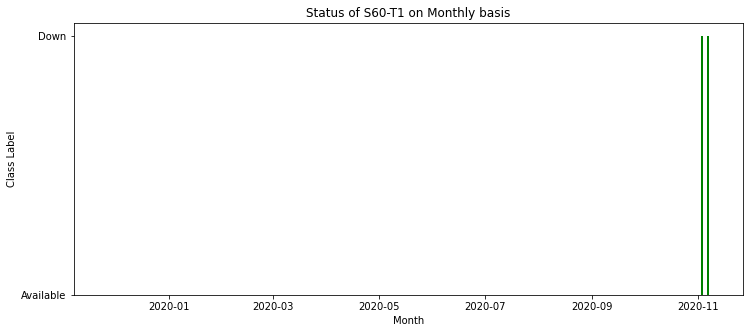

In [33]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[4]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[4]]))

f.show()

#### Top Available terminals after 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

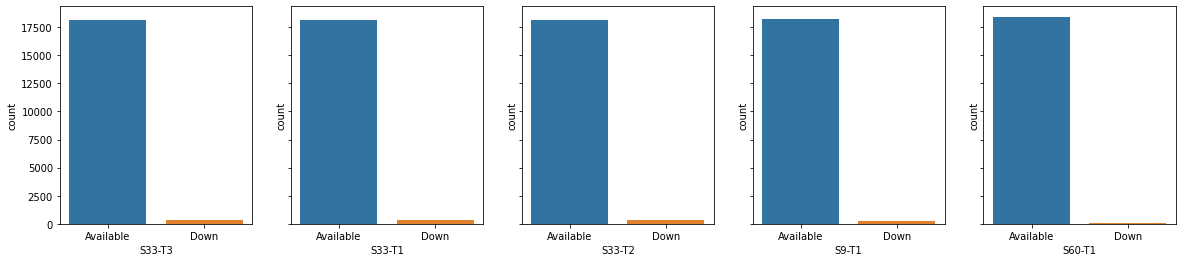

In [34]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour>9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Top available terminals before 9AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

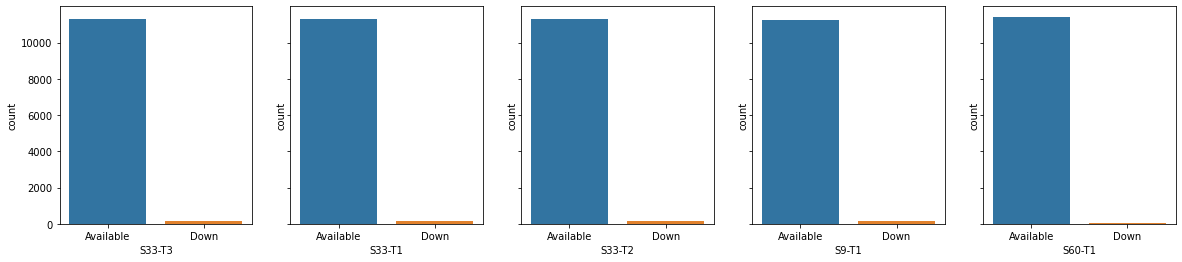

In [35]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour<9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

### observation:
1. Most of the terminals that were available most of the time were not in any other state.
2. That means these may be the new installed terminals at a location where people were not having EV cars

#### Top Terminals that were in charging mode

<bound method Figure.show of <Figure size 1584x360 with 5 Axes>>

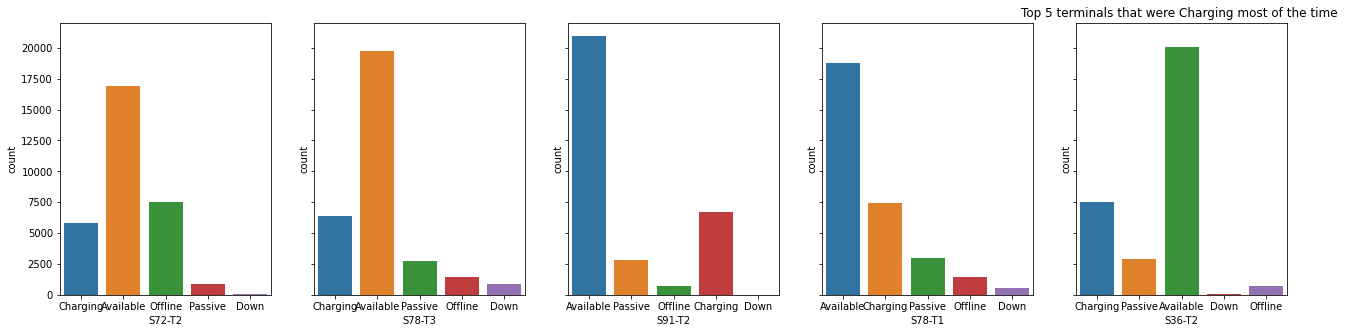

In [36]:
pas_lst=[]
for i in range(0,data.shape[1]):
  try:
    pas_lst.append(data[data.columns[i]].value_counts() .Charging)
  except:
    pas_lst.append(0)
pas_lst=np.argsort(pas_lst)
lst=pas_lst[-5:]

f, axes = plt.subplots(1, 5, sharey=True,figsize=(22, 5))
index=0
for i in lst:
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
plt.title("Top 5 terminals that were Charging most of the time ")
f.show

#### Top charging terminals on weekdays

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

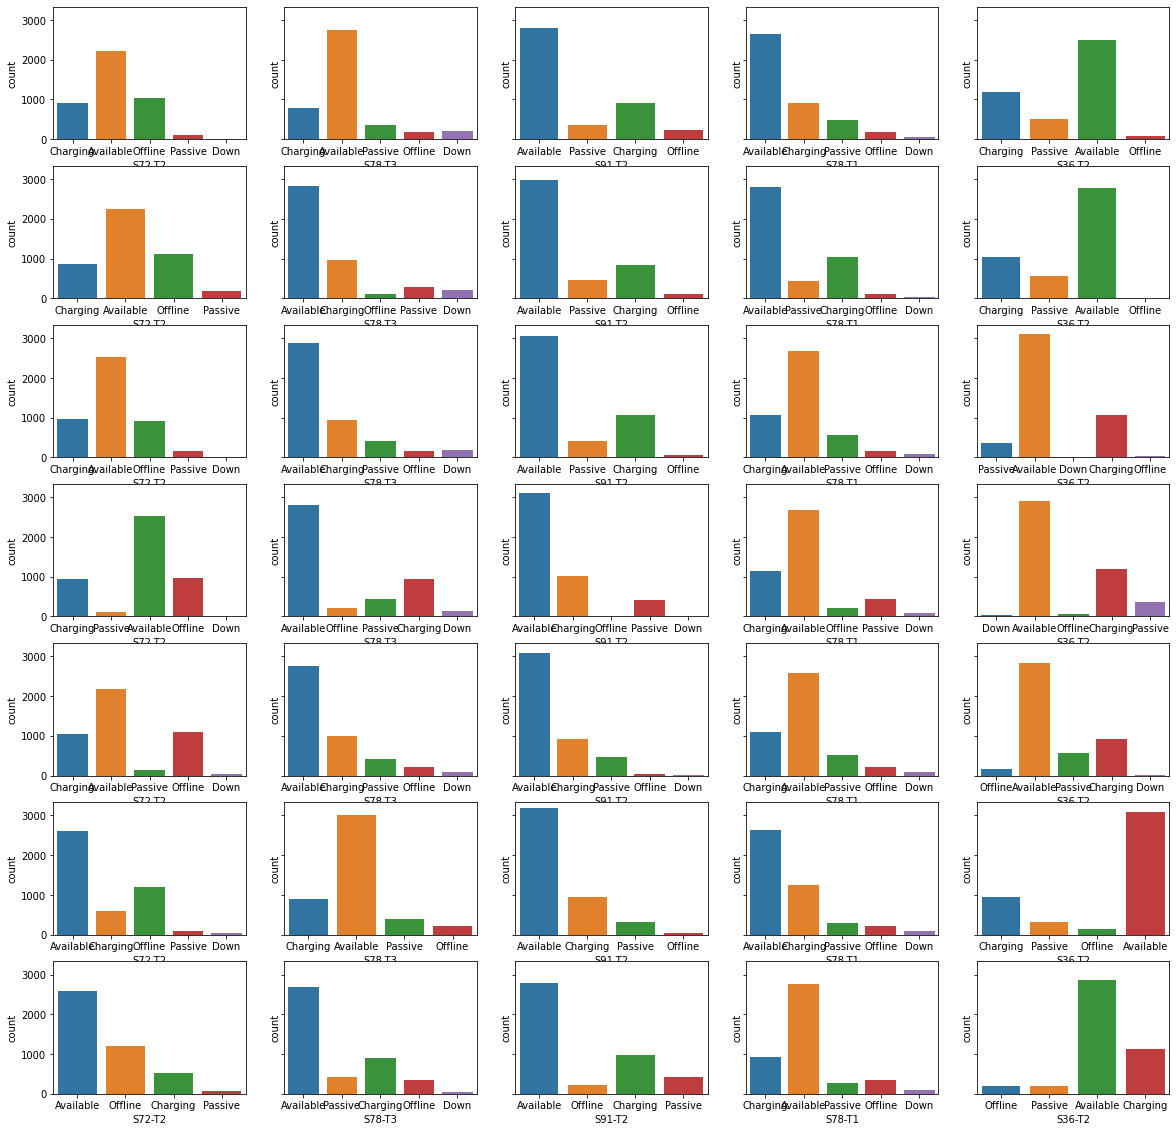

In [37]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in lst: 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

#### Top Charging terminals on Monthly basis

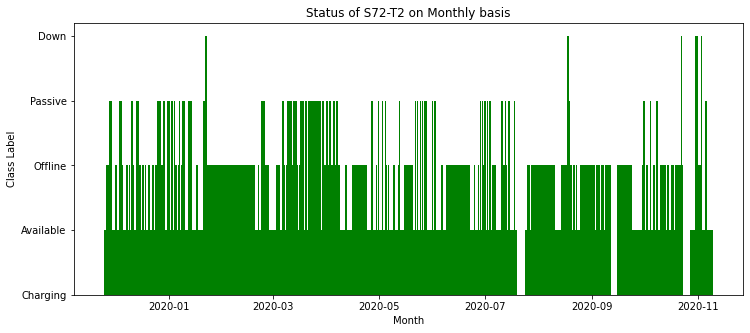

In [39]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[0]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[0]]))

f.show()

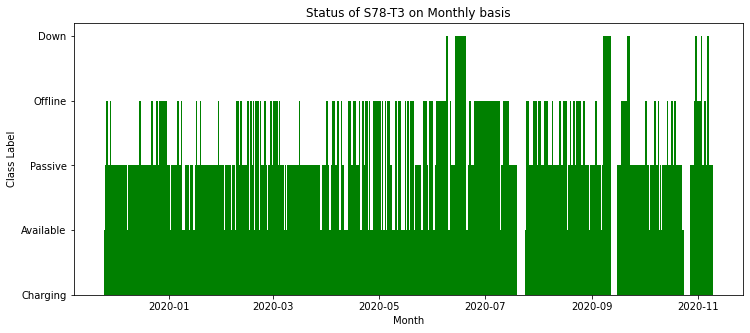

In [40]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[1]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[1]]))

f.show()

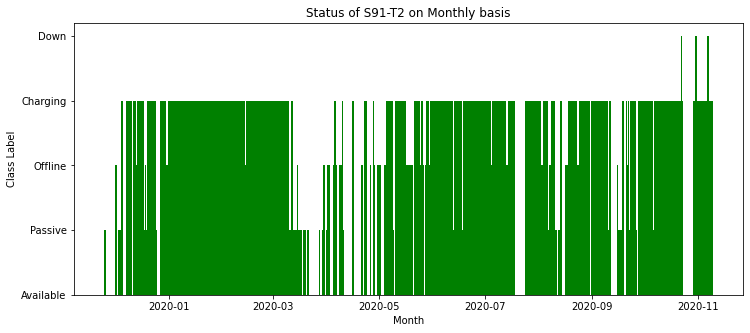

In [41]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[2]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[2]]))

f.show()

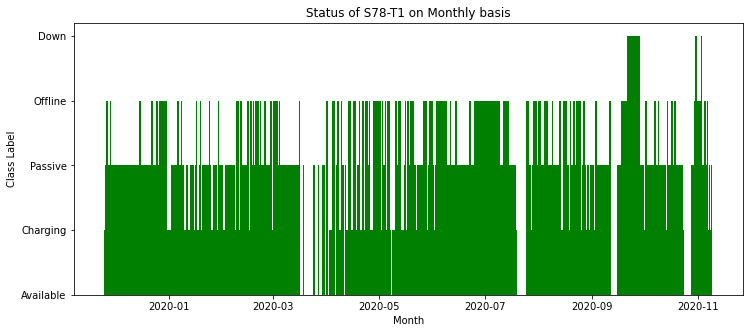

In [42]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[3]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[3]]))

f.show()

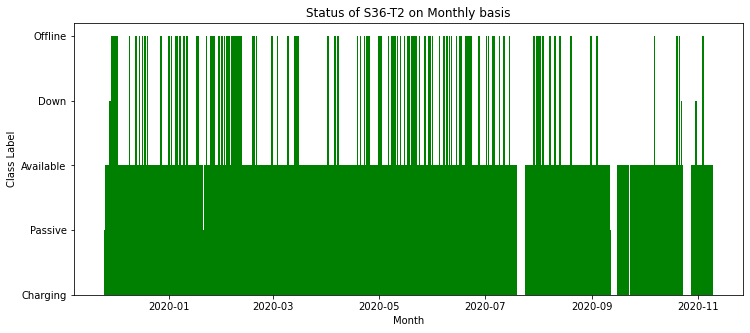

In [43]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[4]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[4]]))

f.show()

#### Top charging terminals After 9 AM 

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

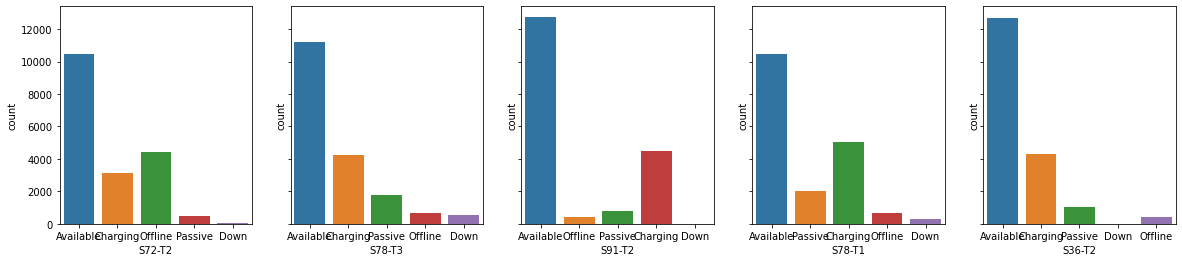

In [44]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour>9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Top Charging terminals before 9 AM 

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

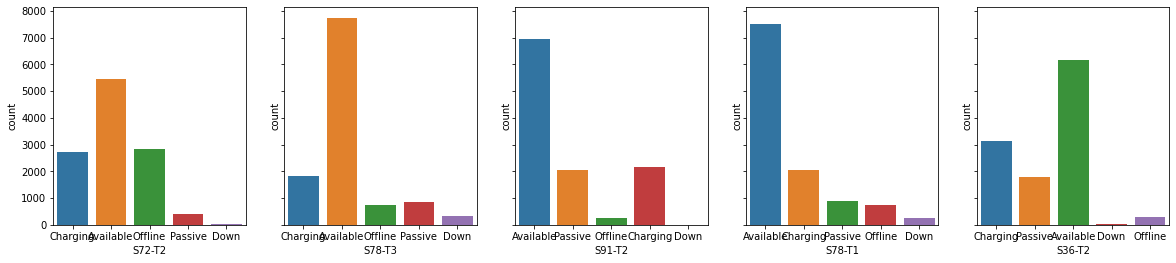

In [45]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour<9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Observations:
1. The number of times these terminals were in charging is very less 

#### Top terminals that were in offline Mode

<bound method Figure.show of <Figure size 1584x360 with 5 Axes>>

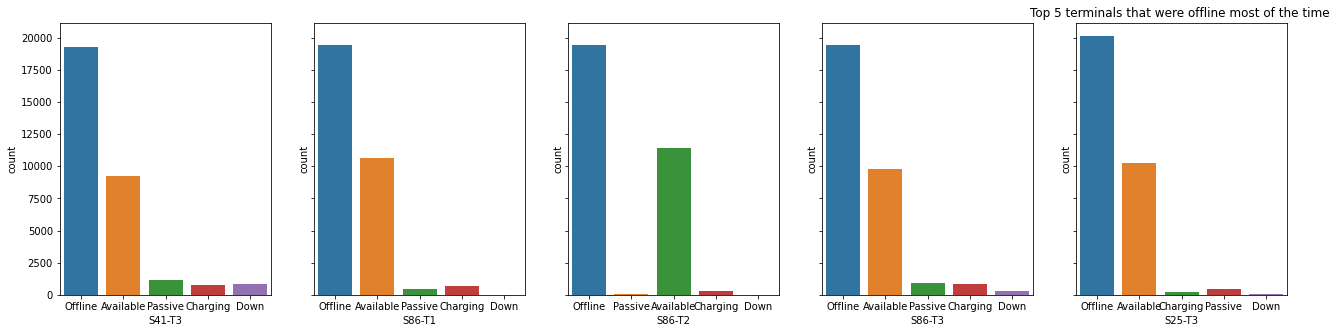

In [46]:
pas_lst=[]
for i in range(0,data.shape[1]):
  try:
    pas_lst.append(data[data.columns[i]].value_counts() .Offline)
  except:
    pas_lst.append(0)
pas_lst=np.argsort(pas_lst)
lst=pas_lst[-5:]

f, axes = plt.subplots(1, 5, sharey=True,figsize=(22, 5))
index=0
for i in lst:
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
plt.title("Top 5 terminals that were offline most of the time ")
f.show

#### Behavior on Weekdays

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

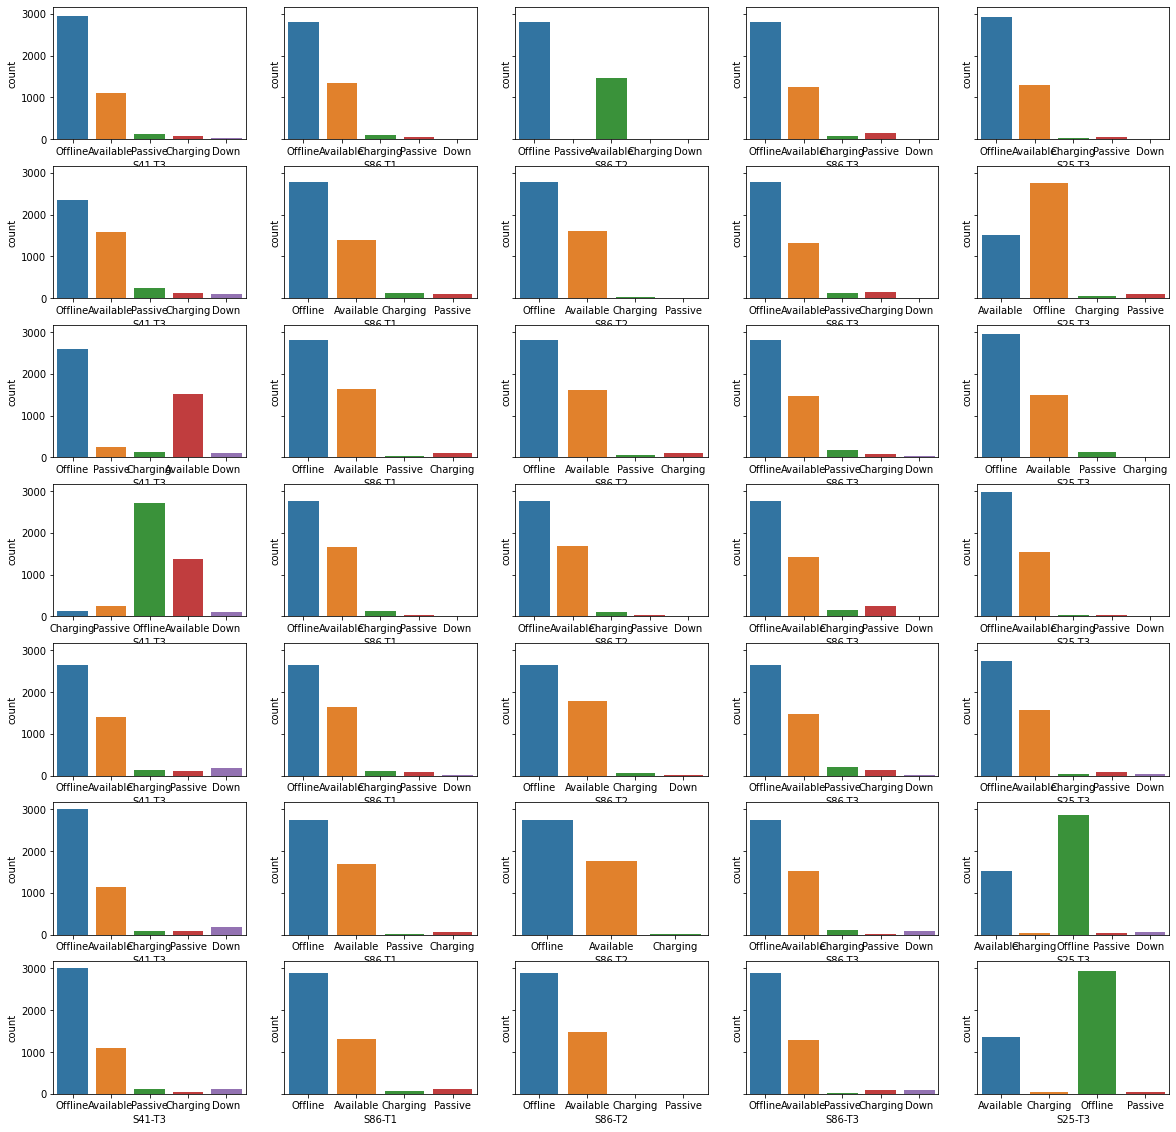

In [47]:


# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in lst: 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

#### Behavior of top 5 terminals on Monthly basis that were mostly in Offline mode

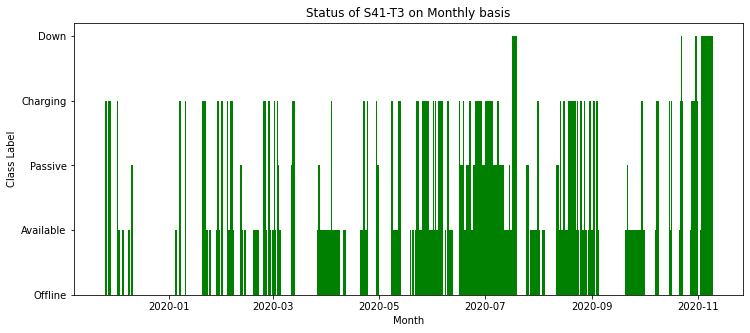

In [53]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[0]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[0]]))

f.show()

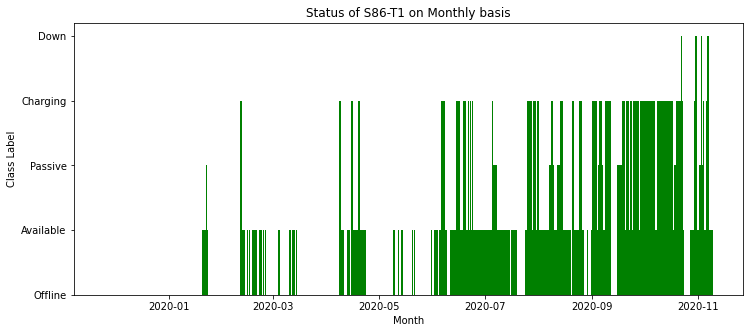

In [54]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[1]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[1]]))

f.show()

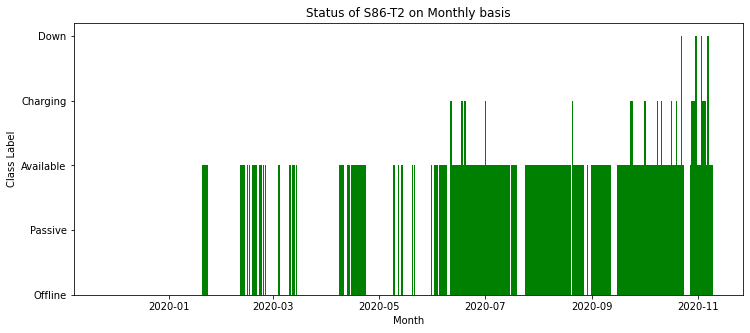

In [50]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[2]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[2]]))

f.show()

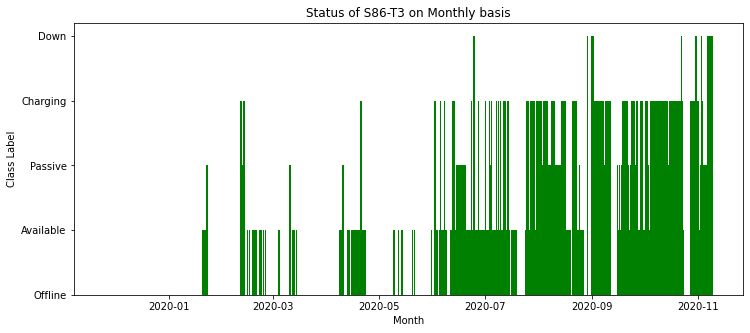

In [51]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[3]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[3]]))

f.show()

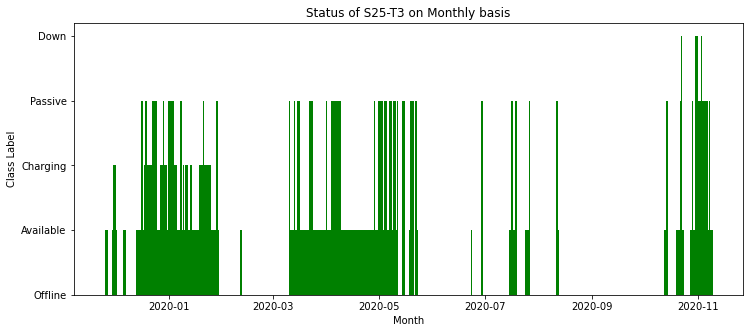

In [52]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[4]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[4]]))

f.show()

#### Behavior before 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

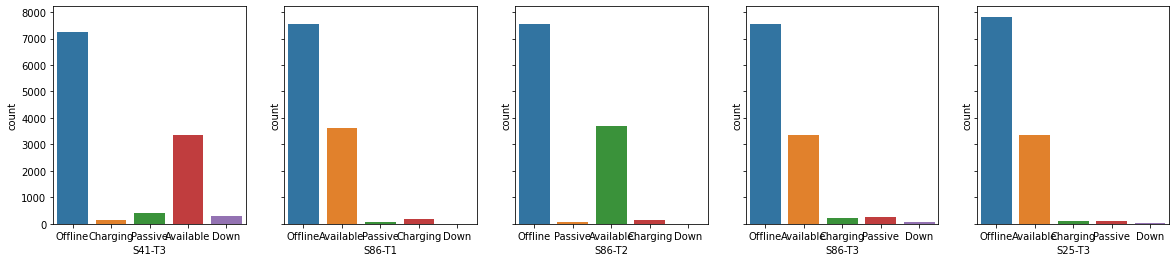

In [55]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour<9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Behavior After 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

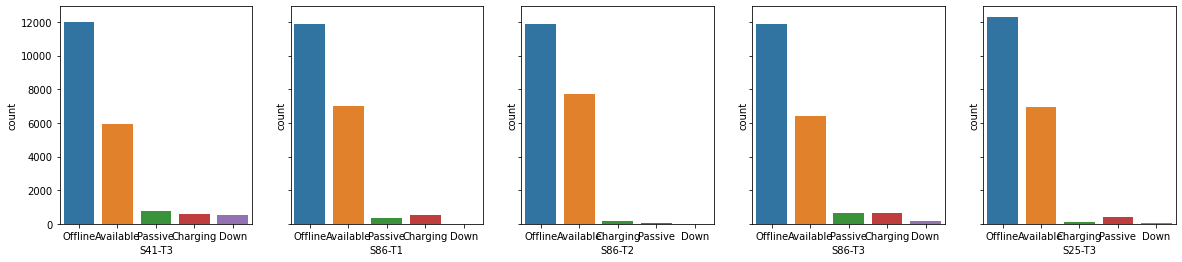

In [56]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour>=9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Top terminals that were DOWN most of the time

<bound method Figure.show of <Figure size 1584x360 with 5 Axes>>

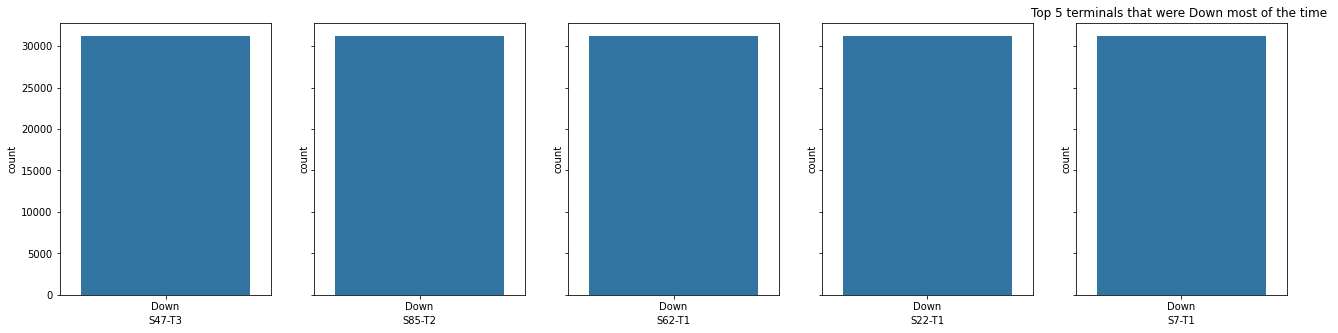

In [57]:
pas_lst=[]
for i in range(0,data.shape[1]):
  try:
    pas_lst.append(data[data.columns[i]].value_counts() .Down)
  except:
    pas_lst.append(0)
pas_lst=np.argsort(pas_lst)
lst=pas_lst[-5:]

f, axes = plt.subplots(1, 5, sharey=True,figsize=(22, 5))
index=0
for i in lst:
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
plt.title("Top 5 terminals that were Down most of the time ")
f.show

####  weekday's  behavior of top 5 terminals that were down for most of the time

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

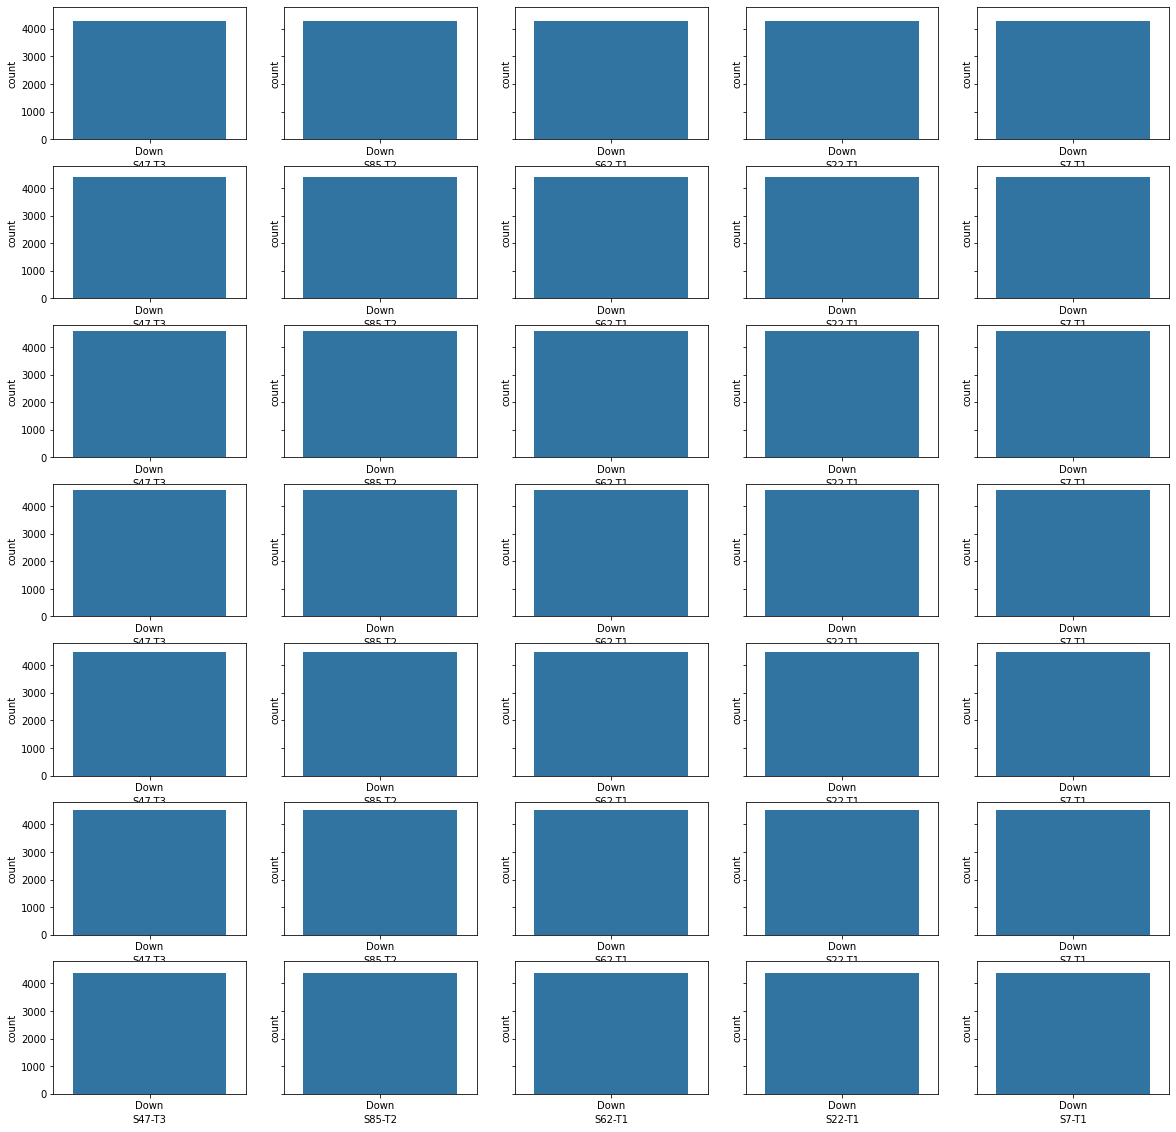

In [58]:

# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in lst: 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

#### Monthly behavior 

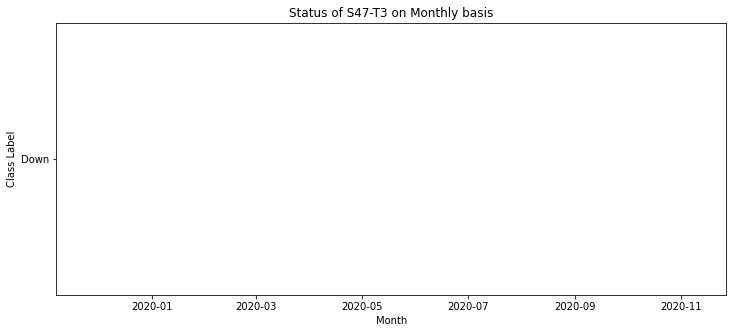

In [59]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[0]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[0]]))

f.show()

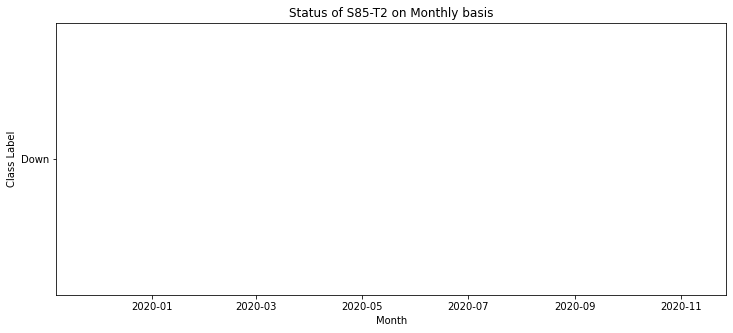

In [60]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[1]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[1]]))

f.show()

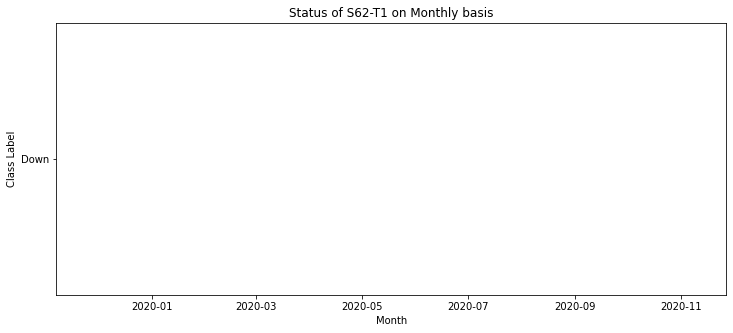

In [61]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[2]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[2]]))

f.show()

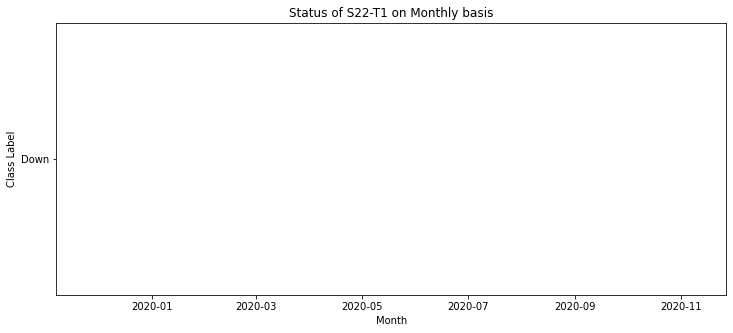

In [62]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[3]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[3]]))

f.show()

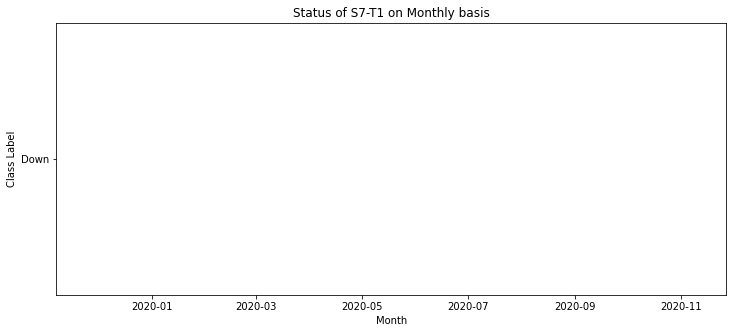

In [63]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data[data.columns[lst[4]]], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Month", ylabel="Class Label", title= 'Status of {0} on Monthly basis'.format(data.columns[lst[4]]))

f.show()

#### Behavior before 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

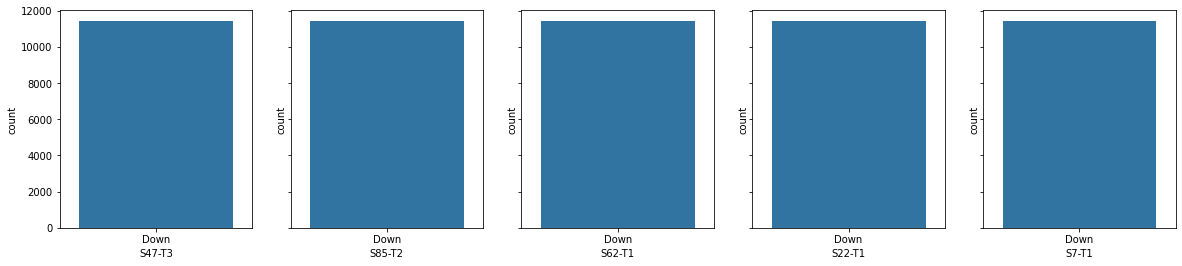

In [64]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour<9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Behavior After 9 AM

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

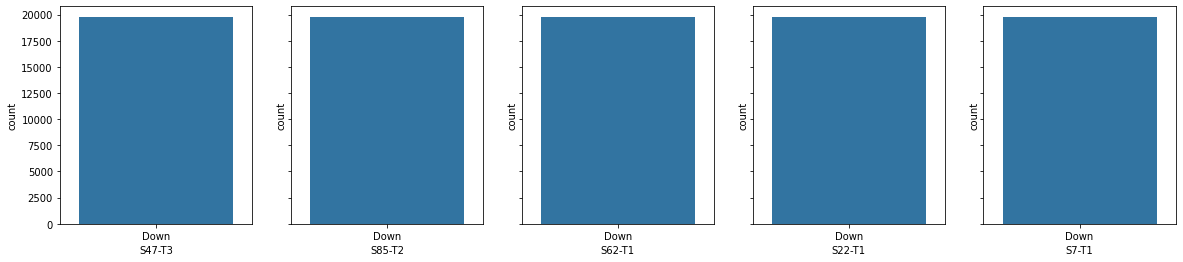

In [65]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0

index=0
for i in lst: 
  sns.countplot(x=data.index.hour>=9, data=data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
        
  index+=1
f.show

#### Observations
1. The terminals that are in Down mode may be they need repair or it may be possibel that these terminals were never repaired
2. It can be observed that may be the terminals that were down, their corresponding stations are also down.
3. These terminals are also down on the weekdays 


<AxesSubplot:>

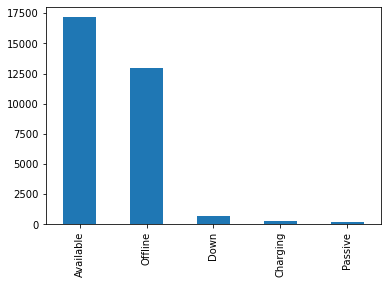

In [ ]:
data['S2-T1'].value_counts().plot.bar() # Printing the bar plot of the class label counts

Plotting the distribution of class labels because there are 274 different time series, i will plot only a subset of them

<bound method Figure.show of <Figure size 1296x288 with 5 Axes>>

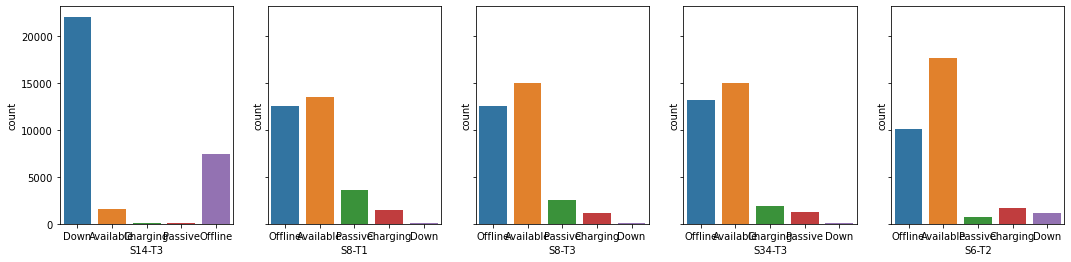

In [ ]:
# Plotting the count of status of random 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(18, 4))
index=0
for i in range(10, 15): 
    sns.countplot(data[data.columns[i]], ax=axes[index]) # plotting the Individual columns class labels
    index+=1
f.show

<bound method Figure.show of <Figure size 1296x288 with 5 Axes>>

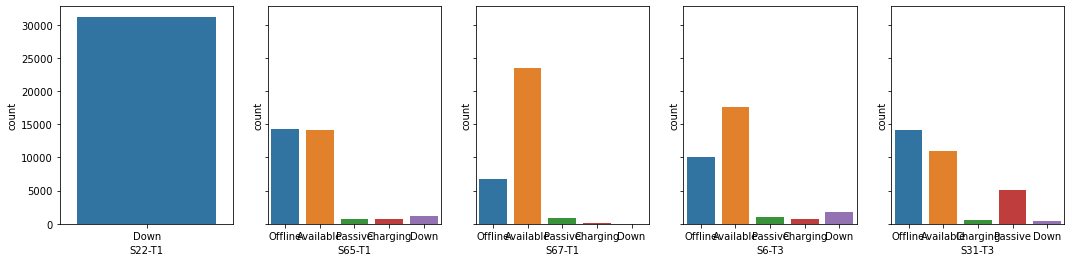

In [ ]:
# Plotting the count of status of random 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(18, 4))
index=0
for i in range(100, 105):
    
    sns.countplot(data[data.columns[i]], ax=axes[index])# Selecting the particular column to make a count plot
    index+=1
f.show

<bound method Figure.show of <Figure size 1440x288 with 5 Axes>>

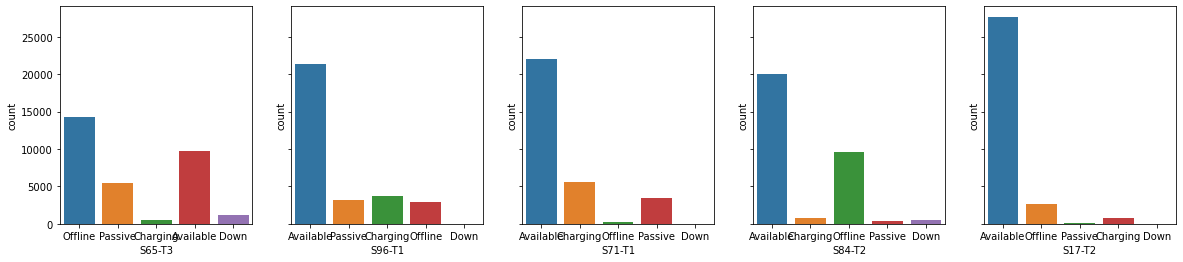

In [ ]:
# Plotting the count of status of random 5 terminals 
f, axes = plt.subplots(1, 5, sharey=True,figsize=(20, 4))
index=0
for i in range(200, 205):
    
    sns.countplot(data[data.columns[i]], ax=axes[index]) # Selecting the particular column to make a count plot
    index+=1
f.show

### Observation
1. This is imbalanced time series classification problem.
2. Most of the time Many terminals are down.
3. A very few number of times a unique terminal is in charging mode.

### Monthly status of a terminal

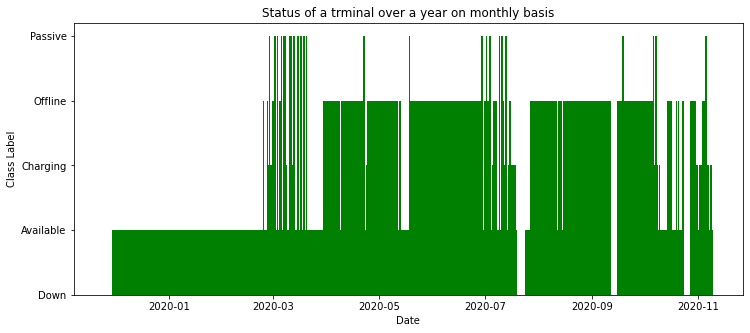

In [ ]:
# Create figure and plot space
f, axes = plt.subplots(figsize=(12, 5))

# Add x-axis and y-axis
axes.bar(data.index.values, data['S2-T1'], color='green') # Selecting the particular column to make a count plot

# Set title and labels for axes
axes.set(xlabel="Date", ylabel="Class Label", title="Status of a trminal over a year on monthly basis")

f.show()

### Observation
It can be seen that most of the time the particular terminal is available and for a very less amount of time its passive that means it was connected but not charging the car

### Status of a terminal on hourly basis

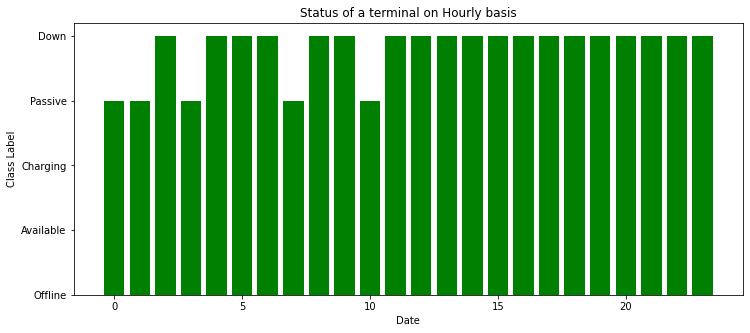

In [ ]:
# Create figure and plot space
fig, axes = plt.subplots(figsize=(12,5))

# Add x-axis and y-axis
axes.bar(data.index.hour,data['S94-T3'],color='green')

# Set title and labels for axes
axes.set(xlabel="Date", ylabel="Class Label", title="Status of a terminal on Hourly basis")

f.show()

### observation:
This particular terminal is Down most of the hours 

### Plotting the terminal usage over weekdays

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

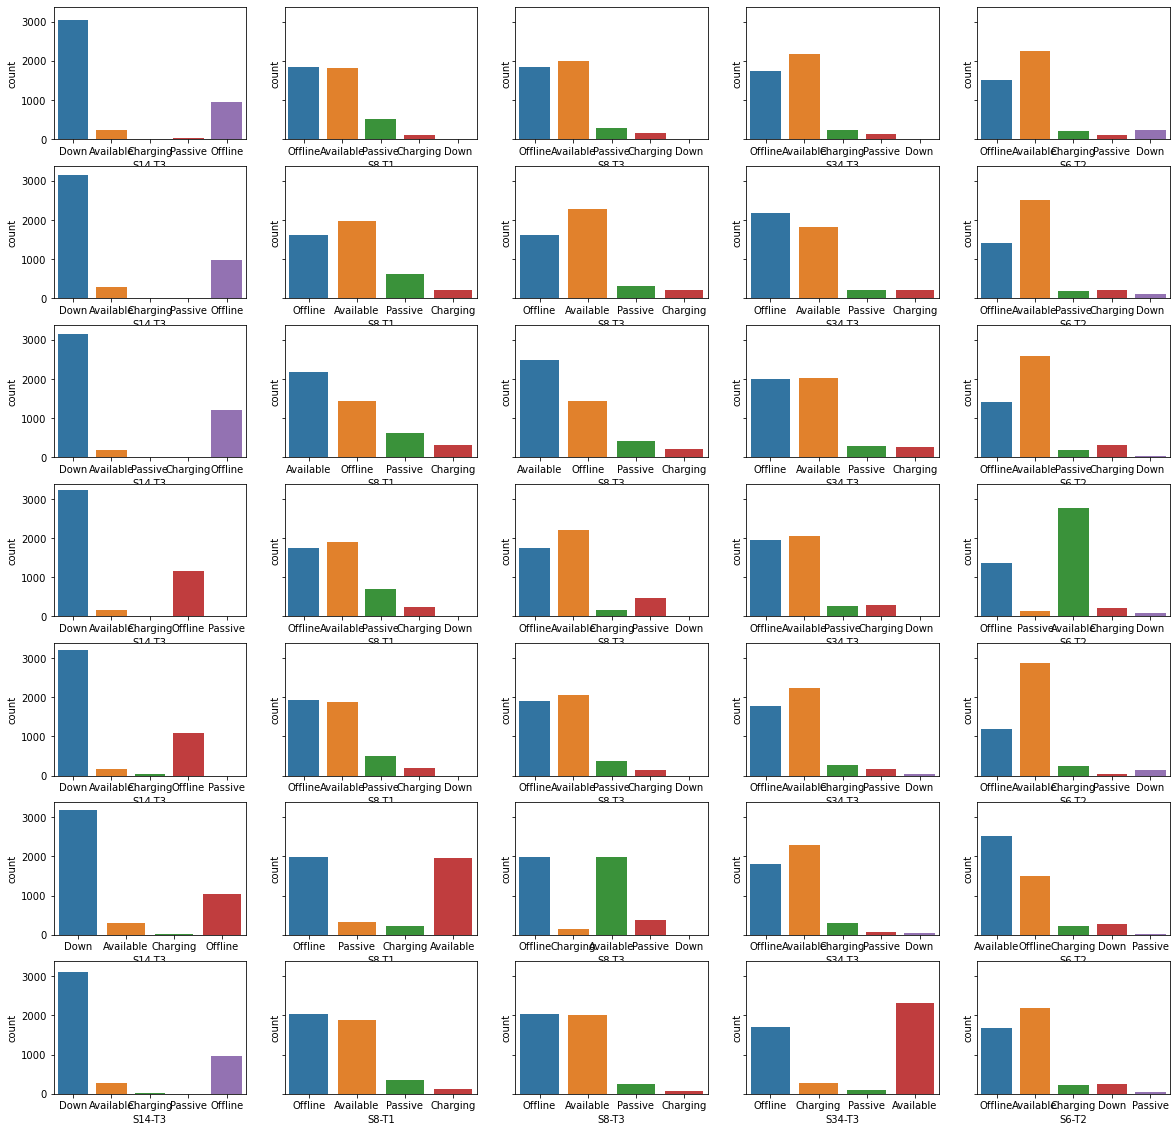

In [ ]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in range(10, 15): 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

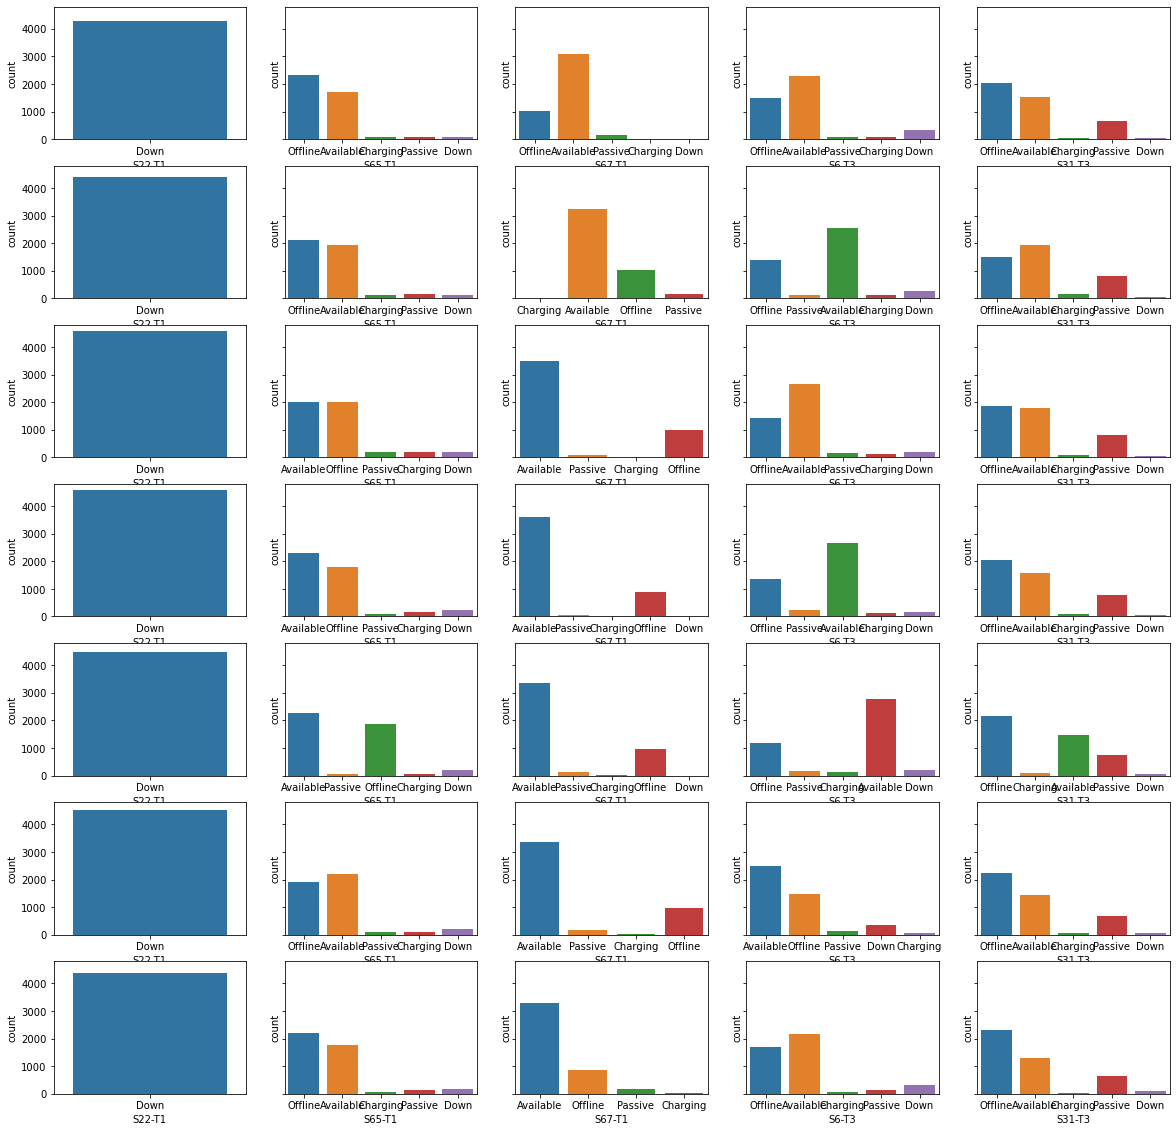

In [ ]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in range(100, 105): 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

<bound method Figure.show of <Figure size 1440x1440 with 35 Axes>>

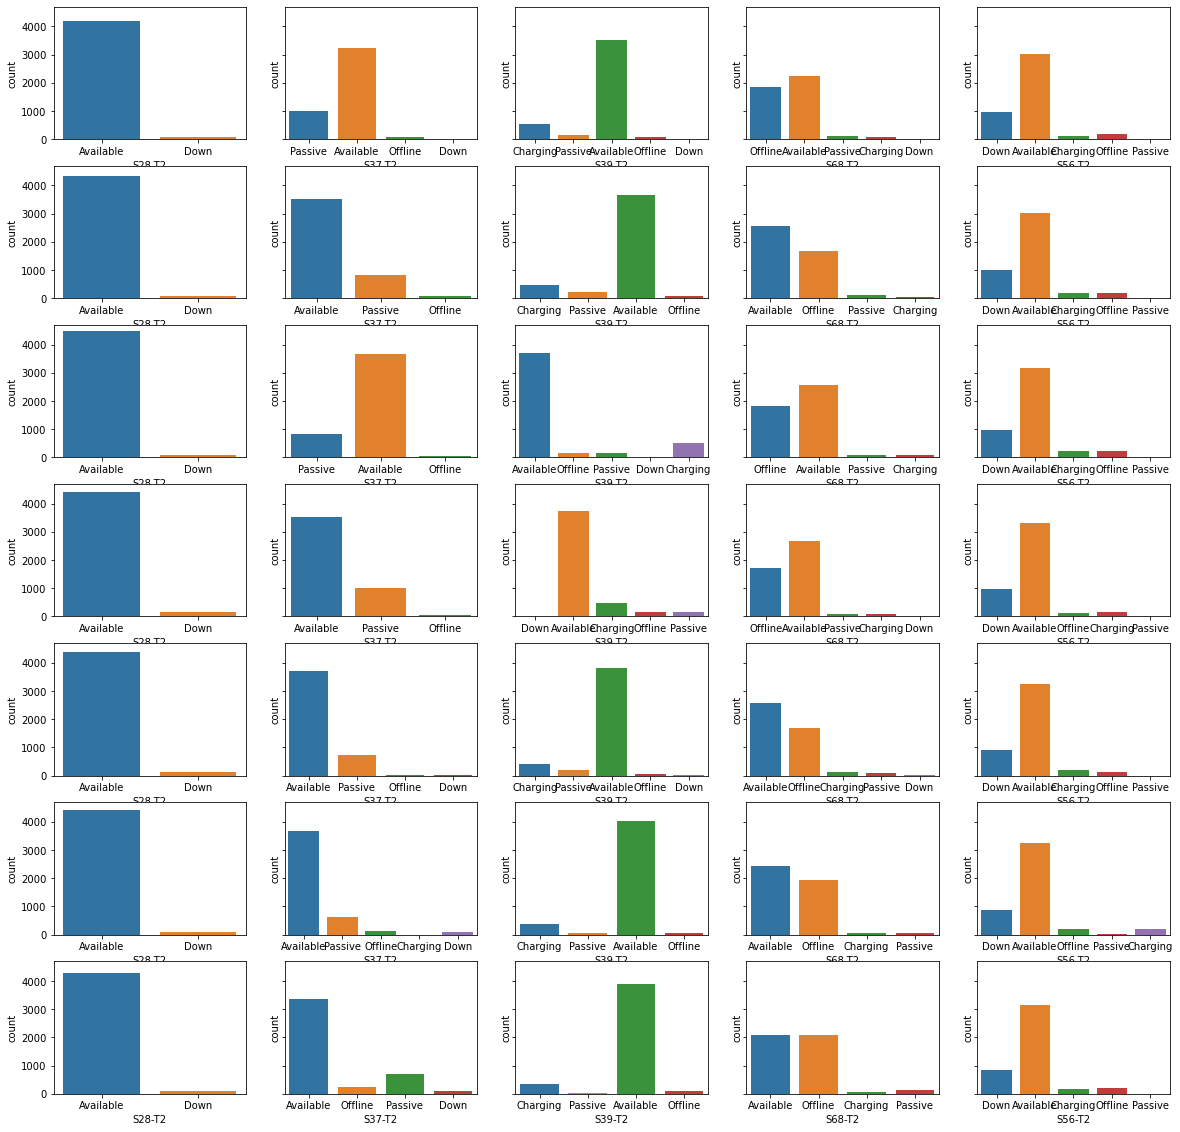

In [ ]:
# Plotting the count of status of some 5 terminals 
f, axes = plt.subplots(7, 5, sharey=True,figsize=(20, 20))
index=0

for wkday in range(0,7): # Plotting the status of various terminals over weekdays
    index=0
    for i in range(250, 255): 
        sns.countplot(x=data.index.weekday==wkday, data=data[data.columns[i]], ax=axes[wkday, index]) # plotting the Individual columns class labels
        
        index+=1
f.show

### Observations:
1. From the above countplots it can be seen that there are some terminal that are in Charging mode.
2. A less number of vehicle are in charging mode on weekends.
3. If some of the terminals are then its likely that most of the time they are down 